In [2]:
# Ensure relevant packages are installed
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install biopython
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install hyperopt

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=6bcbc5c064a6c4f23edd858c628f179ca48892eea5521d42dda59f0f97c5509c
  Stored in directory: /home/marie/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn
     |████████████████████████████████| 1.6 MB 963 kB/s eta 0:00:01


     |████████████████████████████████| 198 kB 2.5 MB/s eta 0:00:01


In [1]:
from Bio import SeqIO
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
"""
Does not work

#Encode a single protein sequence into a vector with 96*20 = 1920 binary variables
def one_hot_encoder(MSA_str, alphabet):
    # define a mapping of characters to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    # integer encode input data
    integer_encoded = [char_to_int[char] for char in MSA_str]
    # one hot encode integers
    onehot_encoded = list()
    for value in integer_encoded:
        if value == char_to_int.get("-"):
            letter = [0 for value in range(len(alphabet)-1)]
        else:
            letter = [0 for value in range(len(alphabet)-1)]
            letter[value] = 1
        onehot_encoded.append(letter)
        
    #At this point, we have 96 vectors of 20 binary variables, one vector per letter
    #Concatenate them to have one vector of 1920 variables
    concatenated = onehot_encoded[0]
    for i in range(len(onehot_encoded)-1):
        concatenated = np.concatenate((concatenated, onehot_encoded[i+1]), axis = None)
        
    return concatenated"""
#One-hot encoder

def one_hot_encoder(sequence, alphabet):
    """
    Input : sequence "--ATCGQRT-W-" for instance
    Output : numpy array, one line = one amino acid hot-encoded (or gap -)
    """
    X_in_seq = "X" in sequence
    if X_in_seq == True :
        return "to_remove"
    else :
        m = np.eye(20) #identity matrix, 20 amino acids
        m = np.vstack([m, np.zeros(20)]) #add zero line for '-', same length as amino acids hot encoding
        mapping = dict(zip(("ACDEFGHIKLMNPQRSTVWY-"), range(21))) #mapping of the sequence to encode
        sequence_mapped = [mapping[i] for i in sequence] #mapped sequence ("ACDE-" --> [0,1,2,3,20])  
        return m[sequence_mapped].reshape(len(sequence)*20) #takes the line of 0&1s from m that corresponds to the mapping

#test 
#one_hot_encode("AD-")

In [2]:
#Use one_hot_encoder on all the elements in one file: end up with N vectors of 1920 variables
def read_and_encode(file, alphabet):
    
    #Store relevant data in dictionary
    #Keys: sequence_number; values: sequence, functionality (functional_true, functional_false)
    data_dict = {}
    index=1
    #name sequences as "sequence_#": do this in roundabout way since third file does not name thep thus
    for seq_record in SeqIO.parse(file, "fasta"):
        data_dict['sequence_' + str(index)] = seq_record.seq
        index += 1
        data_dict[seq_record.id] = seq_record.seq, seq_record.description.replace(seq_record.id+' ','',1)
    
    #Array one: one vector per string => [N, 20*92]
    encoded_data = np.empty([len(data_dict), (len(alphabet)-1)*(len(data_dict['sequence_1'][0]))])
    #Array 2: one binary label per string => [N]
    labels = np.empty(len(data_dict))
    
    #Encode every sequence in the file
    for i in range(len(data_dict)):
        sequence = data_dict.get("sequence_"+str(i+1))[0] #this [0] makes the function crash for the unlabeled file
        encoded_data[i] = one_hot_encoder(sequence, alphabet)
        
        #if functional_true => encode 1 in labels
        if data_dict.get("sequence_"+str(i+1))[1] == "functional_true":
            labels[i]=1
        #if functional_false => encode 0 in labels
        elif data_dict.get("sequence_"+str(i+1))[1] == "functional_false":
            labels[i]=0
      
    return encoded_data, labels

#Slightly different for unlabelled data
def read_and_encode_unlab(file, alphabet):
    data_dict = {}
    index=1
    for seq_record in SeqIO.parse(file, "fasta"):
        data_dict['sequence_' + str(index)] = seq_record.seq
        index += 1

    encoded_data_unlab = np.empty([len(data_dict), 1920])
    number_of_corrupted_lines = 0
    corrupted_indexes = []

    for i in range(len(data_dict)):
        sequence = data_dict.get("sequence_"+str(i+1))
        #Some Xs are hanging around in the files, need to avoid them
        try:
            encoded_data_unlab[i] = one_hot_encoder(sequence, alphabet)
        except:
            corrupted_indexes.append(i)
            number_of_corrupted_lines += 1

    print("The number of corrupted sequences is "+ str(number_of_corrupted_lines))

    for i in range(len(corrupted_indexes)):
        encoded_data_unlab = np.delete(encoded_data_unlab, i, axis = 0)
    return encoded_data_unlab

In [3]:
#Read files
#Check that everything works
alphabet ='ACDEFGHIKLMNPQRSTVWY-' #the alphabet we'll use the whole time

encoded_data_nat, labels_nat = read_and_encode("./MSA_nat_with_annotation.faa", alphabet)
print("The shapes of the oneshot encoded natural data and of the label files are " + str(np.shape(encoded_data_nat)) + " and " + str(np.shape(labels_nat))+" respectively")

encoded_data_art, labels_art = read_and_encode("./MSA_art.faa", alphabet)
print("The shapes of the oneshot encoded artificial data and of the label files are " + str(np.shape(encoded_data_art)) + " and " + str(np.shape(labels_art))+" respectively")

all_lab_data = np.concatenate((encoded_data_art, encoded_data_nat))
all_lab = np.concatenate((labels_nat, labels_art))
print("The shapes of all the oneshot encoded labeled data and of their label file are " + str(np.shape(all_lab_data)) + " and " + str(np.shape(all_lab))+" respectively")

encoded_data_unlab = read_and_encode_unlab("./MSA_nat_no_annotation.faa", alphabet)
print("The shape of the oneshot encoded unlabeled data is " + str(np.shape(encoded_data_unlab)))

The shapes of the oneshot encoded natural data and of the label files are (1130, 1920) and (1130,) respectively
The shapes of the oneshot encoded artificial data and of the label files are (1003, 1920) and (1003,) respectively
The shapes of all the oneshot encoded labeled data and of their label file are (2133, 1920) and (2133,) respectively
The number of corrupted sequences is 42
The shape of the oneshot encoded unlabeled data is (6269, 1920)


In [5]:
from Bio import SeqIO
import sys
import numpy as np

encoded_data_art = [one_hot_encoder(entry.seq, alphabet) for entry in SeqIO.parse("MSA_art.faa", "fasta")] #artificial sequences
encoded_data_unlab = [one_hot_encoder(entry.seq, alphabet) for entry in SeqIO.parse("MSA_nat_no_annotation.faa", "fasta")]#natural without annotation
encoded_data_nat = [one_hot_encoder(entry.seq, alphabet) for entry in SeqIO.parse("MSA_nat_with_annotation.faa", "fasta")] #natural
encoded_data_unlab = [item for item in encoded_data_unlab if item != "to_remove"]

#full_data = art + nat_no + nat_yes
#annot_data = art + nat_yes
all_lab_data = np.concatenate((encoded_data_art,encoded_data_nat))


<ipython-input-5-45047edae754>:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  encoded_data_unlab = [item for item in encoded_data_unlab if item != "to_remove"]


In [6]:
labels_nat = [1 if "true" in entry.description else 0 for entry in SeqIO.parse("MSA_nat_with_annotation.faa", "fasta")]
labels_art = [1 if "true" in entry.description else 0 for entry in SeqIO.parse("MSA_art.faa", "fasta")]

#func_annot_data = func_art + func_nat_yes
all_lab = np.concatenate((labels_art, labels_nat))

In [7]:
#Exercice 2: apply PCA
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt

#Standardizing the features: not needed - data is already scaled. But if we did:
#from sklearn.preprocessing import StandardScaler
#encoded_data = StandardScaler().fit_transform(encoded_data)
def apply_PCA(encoded_data):

    #Find number of components such that we keep, say, 95% of the variance when applying
    pca_test = PCA().fit(encoded_data)
    n_components= np.where(np.cumsum(pca_test.explained_variance_ratio_) > 0.95)
    min_n = n_components[0][0]
    print("With " + str(min_n) + " components, we keep 95% of the variance!")
    
    fig = plt.figure(figsize=(8,8))
    plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
    plt.axvline(x=min_n, color='red', linestyle='--')
    plt.xlabel("number of components")
    plt.ylabel("cumulative explained variance")

    
    #Apply PCA with this optimal n
    pca = PCA(n_components=min_n)
    pcs_nat = pca.fit_transform(encoded_data_nat)
    principalComponents = pca.transform(encoded_data)

    two_compo_var = (pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100
    print("With the first 2 components, we only keep " + str(two_compo_var) + "% of the variance")
    
    return principalComponents

#Visualize the first two principle components
def visualize_pcs(principalComponents, labels, title):
    #red => 0 => functional_false; green => 1 => functional_true
    if(labels is None):
        colors = []
    else:
        colors = ['red','green']
        
    fig = plt.figure(figsize=(8,8))
    plt.scatter(principalComponents[:,0], principalComponents[:,1], c=labels, marker = '+', 
                cmap=matplotlib.colors.ListedColormap(colors))
    plt.xlabel('Principal Component - 1',fontsize=20)
    plt.ylabel('Principal Component - 2',fontsize=20)
    plt.title(title ,fontsize=20)

We have 1130 natural labelled sequences
With 501 components, we keep 95% of the variance!
With the first 2 components, we only keep 7.638790852685823% of the variance
We have 1003 artificial labelled sequences
With 312 components, we keep 95% of the variance!
With the first 2 components, we only keep 7.638790852685823% of the variance
We have 2133 labelled sequences
With 529 components, we keep 95% of the variance!
With the first 2 components, we only keep 7.638790852685817% of the variance
We have 6269 unlabelled sequences
With 512 components, we keep 95% of the variance!
With the first 2 components, we only keep 7.63879085268583% of the variance


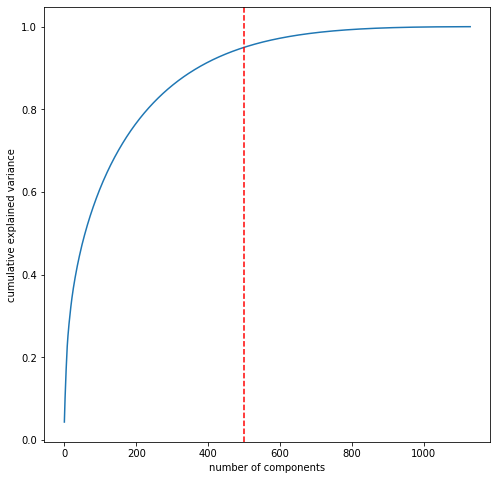

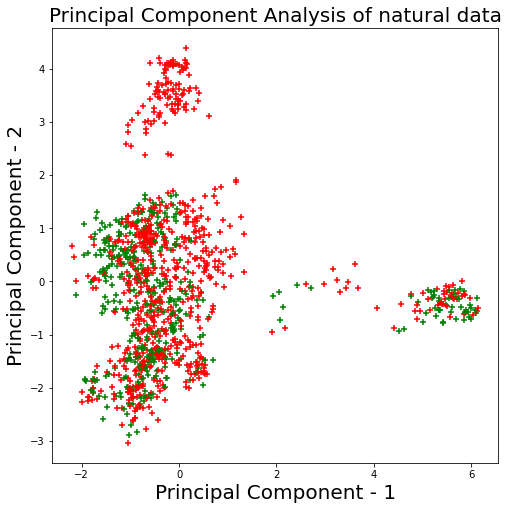

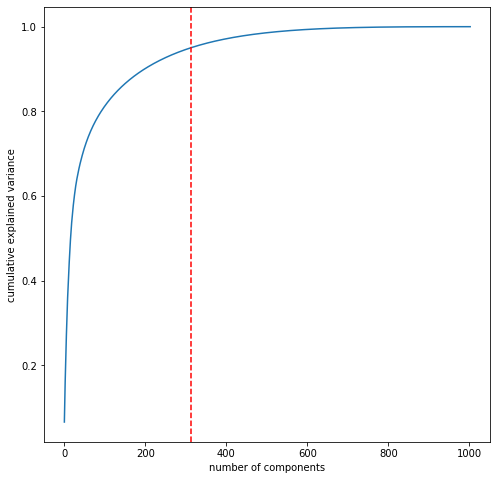

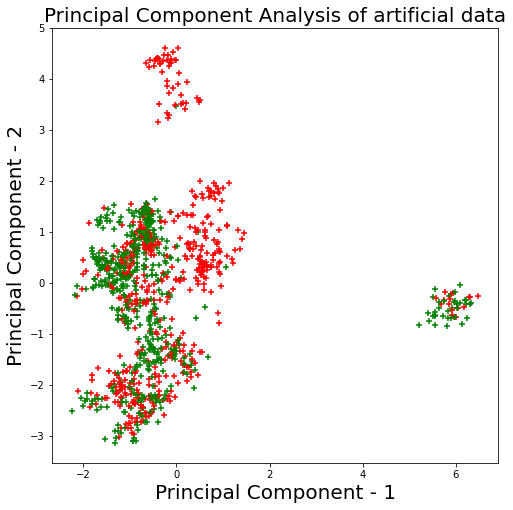

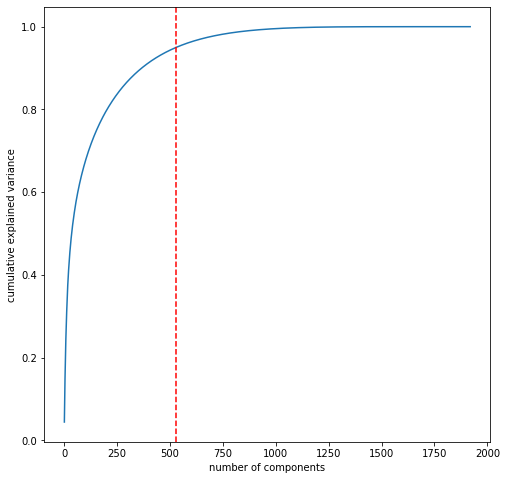

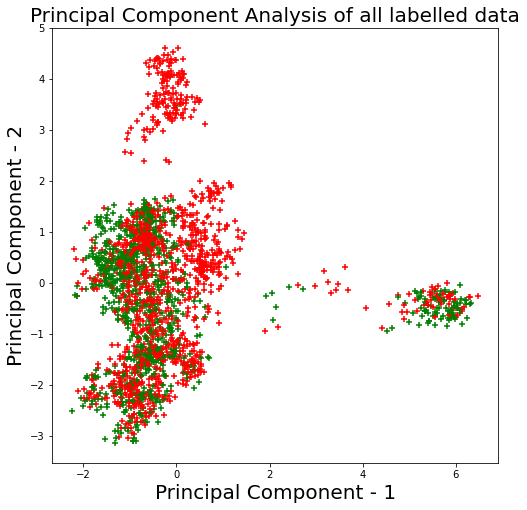

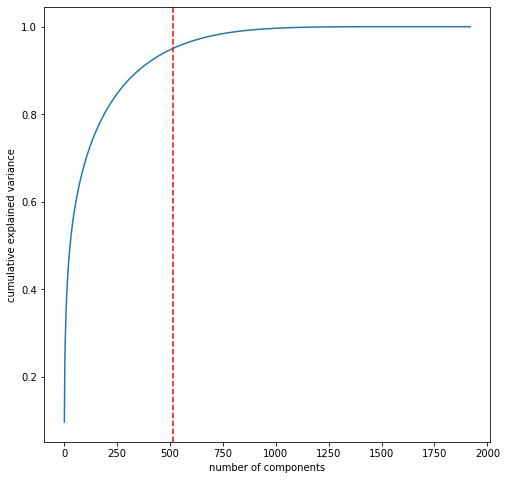

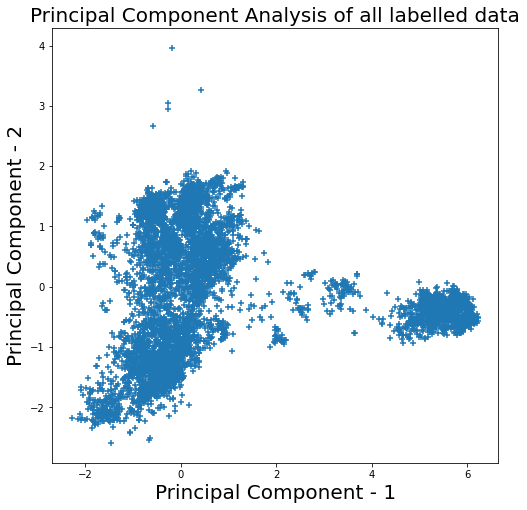

In [8]:
#Try this way, but we'll do it like above I guess
print("We have " + str(np.shape(encoded_data_nat)[0]) + " natural labelled sequences")
pcs_nat = apply_PCA(encoded_data_nat)
visualize_pcs(pcs_nat, labels_nat, "Principal Component Analysis of natural data")

print("We have " + str(np.shape(encoded_data_art)[0]) + " artificial labelled sequences")
pcs_art = apply_PCA(encoded_data_art)
visualize_pcs(pcs_art, labels_art, "Principal Component Analysis of artificial data")

print("We have " + str(np.shape(all_lab_data)[0]) + " labelled sequences")
pcs_all = apply_PCA(all_lab_data)
visualize_pcs(pcs_all, all_lab, "Principal Component Analysis of all labelled data")

print("We have " + str(np.shape(encoded_data_unlab)[0]) + " unlabelled sequences")
pcs_unlab = apply_PCA(encoded_data_unlab)
visualize_pcs(pcs_unlab, None, "Principal Component Analysis of all labelled data")

In [9]:
#We'll use 500
modelPCA = PCA(n_components=500)

pcs_nat = modelPCA.fit_transform(encoded_data_nat)
pcs_art = modelPCA.transform(encoded_data_art)
all_pcs = modelPCA.transform(all_lab_data)
unlab_pcs = modelPCA.transform(encoded_data_unlab)

In [10]:
#Exercice 3: clustering

from sklearn.cluster import AgglomerativeClustering

def compo_cluster(data, pcs, title, n):

    method = AgglomerativeClustering(n_clusters = n)
    clustered = method.fit(data)
    labels = clustered.labels_
    colors = ['red','green']

    fig = plt.figure(figsize=(8,8))
    plt.scatter(pcs[:,0], pcs[:,1], c=labels, marker = '+')
            #cmap=matplotlib.colors.ListedColormap(colors))
    plt.xlabel('Principal Component - 1',fontsize=20)
    plt.ylabel('Principal Component - 2',fontsize=20)
    plt.title(title)

  0%|          | 0/8 [00:51<?, ?it/s]


KeyboardInterrupt: 

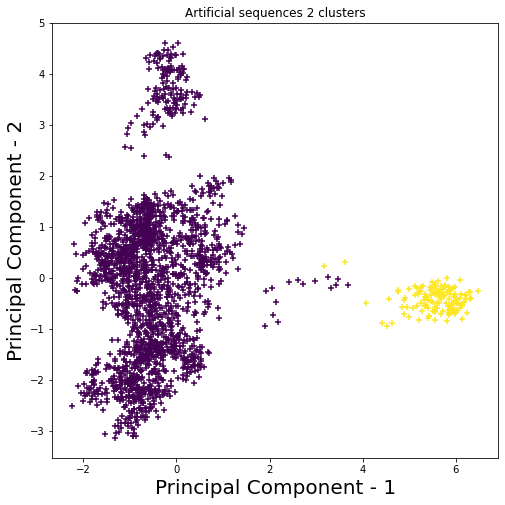

In [13]:
from tqdm import tqdm
for i in tqdm(range(8)):
    #compo_cluster(encoded_data_nat, pcs_nat, "Natural sequences " + str(i+2) + " clusters", i+2)
    #compo_cluster(encoded_data_art, pcs_art, "Artificial sequences " + str(i+2) + " clusters", i+2)
    compo_cluster(all_lab_data, all_pcs, "Artificial sequences " + str(i+2) + " clusters", i+2)
    compo_cluster(encoded_data_unlab, unlab_pcs, "Artificial sequences " + str(i+2) + " clusters", i+2)

In [14]:
#Supervised learning: NN
import random
from keras import losses, optimizers, metrics, callbacks
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Input, Dense, Add, Dropout
                
params = {
        # https://keras.io/guides/sequential_model/
    'hidden_layers': {
            'units': 64,
            'activation': 'relu',
            'use_bias': True,
            'kernel_initializer': 'GlorotUniform',
            'kernel_regularizer': None,
            'bias_regularizer': 'l2',
            'activity_regularizer': None,
            'kernel_constraint': None,
            'bias_constraint': None
            },
    'compilation': {
            'optimizer': Adam(
                learning_rate=0.001
                ),
            'loss': losses.MeanSquaredError(),
            'metrics': [metrics.MeanSquaredError(), metrics.MeanAbsoluteError()],
        },
    'fit': {
        'batch_size': 32,
        'epochs': 100,
        'callbacks' : [
            callbacks.EarlyStopping(monitor='loss', patience=7), 
            callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)]
            }
          }

#Need to shuffle the data
input_data = all_pcs
#input_data = all_pcs
output_data = all_lab

print(np.shape(input_data))
# Steps to shuffle:
joined_lists = list(zip(input_data, output_data))
random.shuffle(joined_lists) # Shuffle "joined_lists" in place
input_data, output_data = zip(*joined_lists) # Undo joining
input_data = np.array(input_data)
output_data = np.array(output_data)
print(np.shape(input_data))

def create_DNN(input_data, hidden_layers_params, dropout_rate):
    model = Sequential() 
    input_layer = Dense(32, input_shape=(np.shape(input_data)[1],)) 
    model.add(input_layer) 
    hidden_layer = Dense(**hidden_layers_params)
    model.add(hidden_layer)
    dropout_layer = Dropout(dropout_rate)
    model.add(dropout_layer)
    hidden_layer = Dense(**hidden_layers_params)
    model.add(hidden_layer) 
    output_layer = Dense(1, activation='sigmoid') 
    model.add(output_layer)
    
    return model

#Set up network
model = create_DNN(all_pcs, params['hidden_layers'], dropout_rate=0.25)
model.compile(**params['compilation'])

(2133, 500)
(2133, 500)


In [15]:
#Def fraction train/test/validation
fraction_train = 0.8
fraction_test = 0.1

stop_1 = int(fraction_train*len(output_data))
stop_2 = stop_1 + int(fraction_test*len(output_data))

X_train, Y_train = input_data[:stop_1], output_data[:stop_1]
X_test, Y_test = input_data[stop_1+1:stop_2], output_data[stop_1+1:stop_2]
X_validation, Y_validation = input_data[stop_2+1:], output_data[stop_2+1:]

print('Training network (this might take a while)...')
history = model.fit(
    X_train,
    Y_train,
    validation_data=(X_validation, Y_validation),
    verbose=1,
    **params['fit']
)

Training network (this might take a while)...
Epoch 1/100
54/54 [==============================] - 1s 4ms/step - loss: 0.2287 - mean_squared_error: 0.2285 - mean_absolute_error: 0.4624 - val_loss: 0.1770 - val_mean_squared_error: 0.1766 - val_mean_absolute_error: 0.3886 - lr: 0.0010
Epoch 2/100
54/54 [==============================] - 0s 1ms/step - loss: 0.1524 - mean_squared_error: 0.1520 - mean_absolute_error: 0.3310 - val_loss: 0.1351 - val_mean_squared_error: 0.1347 - val_mean_absolute_error: 0.2873 - lr: 0.0010
Epoch 3/100
54/54 [==============================] - 0s 1ms/step - loss: 0.1159 - mean_squared_error: 0.1155 - mean_absolute_error: 0.2509 - val_loss: 0.1268 - val_mean_squared_error: 0.1263 - val_mean_absolute_error: 0.2569 - lr: 0.0010
Epoch 4/100
54/54 [==============================] - 0s 1ms/step - loss: 0.0972 - mean_squared_error: 0.0967 - mean_absolute_error: 0.2071 - val_loss: 0.1278 - val_mean_squared_error: 0.1274 - val_mean_absolute_error: 0.2397 - lr: 0.0010
Ep

Epoch 35/100
54/54 [==============================] - 0s 1ms/step - loss: 0.0189 - mean_squared_error: 0.0188 - mean_absolute_error: 0.0488 - val_loss: 0.1673 - val_mean_squared_error: 0.1672 - val_mean_absolute_error: 0.2268 - lr: 1.0000e-06
Epoch 36/100
54/54 [==============================] - 0s 1ms/step - loss: 0.0192 - mean_squared_error: 0.0191 - mean_absolute_error: 0.0492 - val_loss: 0.1673 - val_mean_squared_error: 0.1672 - val_mean_absolute_error: 0.2268 - lr: 1.0000e-06
Epoch 37/100
54/54 [==============================] - 0s 1ms/step - loss: 0.0197 - mean_squared_error: 0.0196 - mean_absolute_error: 0.0488 - val_loss: 0.1673 - val_mean_squared_error: 0.1672 - val_mean_absolute_error: 0.2268 - lr: 1.0000e-06
Epoch 38/100
54/54 [==============================] - 0s 1ms/step - loss: 0.0196 - mean_squared_error: 0.0195 - mean_absolute_error: 0.0487 - val_loss: 0.1673 - val_mean_squared_error: 0.1672 - val_mean_absolute_error: 0.2268 - lr: 1.0000e-06


In [16]:
print('Number of epochs run:', len(history.history['loss']))

# Calculate and print scores
print('Evaluating model performance on test set...')
scores = model.evaluate(X_test, Y_test, verbose=0)

max_metrics_name_length = len(max(model.metrics_names, key=len))
print()
print(' Scores '.center(max_metrics_name_length + 13, '='))
line = '{:<%i} : {:.4e}' % max_metrics_name_length
for i in range(len(model.metrics_names)):
    print(line.format(model.metrics_names[i], scores[i]))
print()

Number of epochs run: 38
Evaluating model performance on test set...

============ Scores ============
loss                : 1.9422e-01
mean_squared_error  : 1.9413e-01
mean_absolute_error : 2.5072e-01




Test loss: 0.19421829283237457


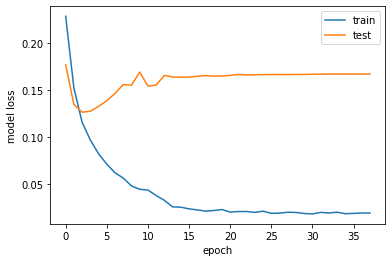

In [17]:
# print performance
print()
print('Test loss:', scores[0])

# look into training history

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [18]:
#That's bad, so we'll try to optimize those parameters with a grid search
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from tensorflow.keras.optimizers import SGD

space={'learning_rate': hp.choice('learning_rate', [0.1, 1, 2, 3]),
       'dropout_rate': hp.choice('dropout_rate', [0., 0.1, 0.25, 0.4]),
       'units': hp.choice('units', [10, 20, 32, 64])
       #'momentum': hp.choice('momentum', [0.001, 0.1, 1])
       #'batch_size': hp.choice('batch_size', [16, 32, 48, 64]),
       #'patience_1': hp.choice('patience_1', [3, 5, 7, 10]),
       #'patience_2': hp.choice('patience_2', [3, 5, 7, 10])
    #'optimizer': hp.choice('optimizer', ['SGD','Adam'])
}

def objective(target):
    
    params = {
        # https://keras.io/guides/sequential_model/
    'hidden_layers': {
            'units': 64,
            'activation': 'relu',
            'use_bias': True,
            'kernel_initializer': 'GlorotUniform',
            'kernel_regularizer': None,
            'bias_regularizer': 'l2',
            'activity_regularizer': None,
            'kernel_constraint': None,
            'bias_constraint': None
            },
    'dropout_rate': 0.25,
    'compilation': {
            'optimizer': SGD(
                learning_rate=0.001,
                momentum=0.1
                ),
            'loss': losses.MeanSquaredError(),
            'metrics': [metrics.MeanSquaredError(), metrics.MeanAbsoluteError()],
            #'momentum': 0.
        },
    'fit': {
        'batch_size': 48,
        'epochs': 100,
        'callbacks' : [
            callbacks.EarlyStopping(monitor='loss', patience=20), 
            callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20)]
            }
          }

    # Create model and train it
    model = create_DNN(all_pcs, params['hidden_layers'], dropout_rate=0.25)
    model.compile(**params['compilation'])
    history = model.fit(
        X_train,
        Y_train,
        validation_data=(X_validation, Y_validation),
        verbose=0,
        **params['fit']
        )
    
    loss=history.history['val_loss'][-1]
    
    return {'loss': loss, 'status': STATUS_OK }

trials=Trials()
best = fmin(objective,
            space, 
            algo=tpe.suggest, 
            trials=trials, 
            max_evals=100
            )

print ("Best result:", best)
print (trials.best_trial)

  1%|          | 1/100 [00:09<16:00,  9.70s/trial, best loss: 0.22240065038204193]


KeyboardInterrupt: 

Epoch 1/500
36/36 [==============================] - 0s 5ms/step - loss: 0.2587 - mean_squared_error: 0.2587 - mean_absolute_error: 0.5023 - val_loss: 0.2585 - val_mean_squared_error: 0.2585 - val_mean_absolute_error: 0.5039 - lr: 0.0010
Epoch 2/500
36/36 [==============================] - 0s 2ms/step - loss: 0.2584 - mean_squared_error: 0.2584 - mean_absolute_error: 0.5022 - val_loss: 0.2573 - val_mean_squared_error: 0.2573 - val_mean_absolute_error: 0.5029 - lr: 0.0010
Epoch 3/500
36/36 [==============================] - 0s 1ms/step - loss: 0.2573 - mean_squared_error: 0.2573 - mean_absolute_error: 0.5016 - val_loss: 0.2561 - val_mean_squared_error: 0.2561 - val_mean_absolute_error: 0.5018 - lr: 0.0010
Epoch 4/500
36/36 [==============================] - 0s 1ms/step - loss: 0.2568 - mean_squared_error: 0.2568 - mean_absolute_error: 0.5008 - val_loss: 0.2550 - val_mean_squared_error: 0.2550 - val_mean_absolute_error: 0.5008 - lr: 0.0010
Epoch 5/500
36/36 [=============================

36/36 [==============================] - 0s 1ms/step - loss: 0.2273 - mean_squared_error: 0.2272 - mean_absolute_error: 0.4692 - val_loss: 0.2293 - val_mean_squared_error: 0.2292 - val_mean_absolute_error: 0.4731 - lr: 0.0010
Epoch 36/500
36/36 [==============================] - 0s 1ms/step - loss: 0.2300 - mean_squared_error: 0.2299 - mean_absolute_error: 0.4720 - val_loss: 0.2286 - val_mean_squared_error: 0.2286 - val_mean_absolute_error: 0.4723 - lr: 0.0010
Epoch 37/500
36/36 [==============================] - 0s 2ms/step - loss: 0.2270 - mean_squared_error: 0.2270 - mean_absolute_error: 0.4687 - val_loss: 0.2280 - val_mean_squared_error: 0.2280 - val_mean_absolute_error: 0.4715 - lr: 0.0010
Epoch 38/500
36/36 [==============================] - 0s 2ms/step - loss: 0.2288 - mean_squared_error: 0.2287 - mean_absolute_error: 0.4702 - val_loss: 0.2274 - val_mean_squared_error: 0.2274 - val_mean_absolute_error: 0.4707 - lr: 0.0010
Epoch 39/500
36/36 [==============================] - 0s 

36/36 [==============================] - 0s 1ms/step - loss: 0.2097 - mean_squared_error: 0.2096 - mean_absolute_error: 0.4447 - val_loss: 0.2110 - val_mean_squared_error: 0.2110 - val_mean_absolute_error: 0.4481 - lr: 0.0010
Epoch 70/500
36/36 [==============================] - 0s 2ms/step - loss: 0.2113 - mean_squared_error: 0.2113 - mean_absolute_error: 0.4460 - val_loss: 0.2105 - val_mean_squared_error: 0.2105 - val_mean_absolute_error: 0.4475 - lr: 0.0010
Epoch 71/500
36/36 [==============================] - 0s 2ms/step - loss: 0.2103 - mean_squared_error: 0.2102 - mean_absolute_error: 0.4449 - val_loss: 0.2101 - val_mean_squared_error: 0.2100 - val_mean_absolute_error: 0.4468 - lr: 0.0010
Epoch 72/500
36/36 [==============================] - 0s 1ms/step - loss: 0.2078 - mean_squared_error: 0.2078 - mean_absolute_error: 0.4424 - val_loss: 0.2096 - val_mean_squared_error: 0.2095 - val_mean_absolute_error: 0.4461 - lr: 0.0010
Epoch 73/500
36/36 [==============================] - 0s 

36/36 [==============================] - 0s 1ms/step - loss: 0.1956 - mean_squared_error: 0.1955 - mean_absolute_error: 0.4227 - val_loss: 0.1962 - val_mean_squared_error: 0.1962 - val_mean_absolute_error: 0.4253 - lr: 0.0010
Epoch 104/500
36/36 [==============================] - 0s 1ms/step - loss: 0.1943 - mean_squared_error: 0.1942 - mean_absolute_error: 0.4206 - val_loss: 0.1958 - val_mean_squared_error: 0.1958 - val_mean_absolute_error: 0.4247 - lr: 0.0010
Epoch 105/500
36/36 [==============================] - 0s 1ms/step - loss: 0.1942 - mean_squared_error: 0.1941 - mean_absolute_error: 0.4202 - val_loss: 0.1954 - val_mean_squared_error: 0.1954 - val_mean_absolute_error: 0.4240 - lr: 0.0010
Epoch 106/500
36/36 [==============================] - 0s 2ms/step - loss: 0.1959 - mean_squared_error: 0.1959 - mean_absolute_error: 0.4222 - val_loss: 0.1950 - val_mean_squared_error: 0.1950 - val_mean_absolute_error: 0.4234 - lr: 0.0010
Epoch 107/500
36/36 [==============================] -

36/36 [==============================] - 0s 1ms/step - loss: 0.1810 - mean_squared_error: 0.1809 - mean_absolute_error: 0.3981 - val_loss: 0.1837 - val_mean_squared_error: 0.1837 - val_mean_absolute_error: 0.4037 - lr: 0.0010
Epoch 138/500
36/36 [==============================] - 0s 1ms/step - loss: 0.1814 - mean_squared_error: 0.1813 - mean_absolute_error: 0.3990 - val_loss: 0.1834 - val_mean_squared_error: 0.1833 - val_mean_absolute_error: 0.4031 - lr: 0.0010
Epoch 139/500
36/36 [==============================] - 0s 2ms/step - loss: 0.1815 - mean_squared_error: 0.1814 - mean_absolute_error: 0.3990 - val_loss: 0.1831 - val_mean_squared_error: 0.1830 - val_mean_absolute_error: 0.4024 - lr: 0.0010
Epoch 140/500
36/36 [==============================] - 0s 2ms/step - loss: 0.1806 - mean_squared_error: 0.1805 - mean_absolute_error: 0.3980 - val_loss: 0.1827 - val_mean_squared_error: 0.1826 - val_mean_absolute_error: 0.4018 - lr: 0.0010
Epoch 141/500
36/36 [==============================] -

36/36 [==============================] - 0s 2ms/step - loss: 0.1723 - mean_squared_error: 0.1721 - mean_absolute_error: 0.3807 - val_loss: 0.1734 - val_mean_squared_error: 0.1732 - val_mean_absolute_error: 0.3831 - lr: 0.0010
Epoch 172/500
36/36 [==============================] - 0s 1ms/step - loss: 0.1699 - mean_squared_error: 0.1698 - mean_absolute_error: 0.3775 - val_loss: 0.1731 - val_mean_squared_error: 0.1730 - val_mean_absolute_error: 0.3825 - lr: 0.0010
Epoch 173/500
36/36 [==============================] - 0s 2ms/step - loss: 0.1683 - mean_squared_error: 0.1682 - mean_absolute_error: 0.3746 - val_loss: 0.1728 - val_mean_squared_error: 0.1727 - val_mean_absolute_error: 0.3820 - lr: 0.0010
Epoch 174/500
36/36 [==============================] - 0s 1ms/step - loss: 0.1688 - mean_squared_error: 0.1687 - mean_absolute_error: 0.3761 - val_loss: 0.1726 - val_mean_squared_error: 0.1724 - val_mean_absolute_error: 0.3814 - lr: 0.0010
Epoch 175/500
36/36 [==============================] -

36/36 [==============================] - 0s 2ms/step - loss: 0.1623 - mean_squared_error: 0.1622 - mean_absolute_error: 0.3624 - val_loss: 0.1654 - val_mean_squared_error: 0.1652 - val_mean_absolute_error: 0.3649 - lr: 0.0010
Epoch 206/500
36/36 [==============================] - 0s 2ms/step - loss: 0.1628 - mean_squared_error: 0.1626 - mean_absolute_error: 0.3611 - val_loss: 0.1652 - val_mean_squared_error: 0.1650 - val_mean_absolute_error: 0.3645 - lr: 0.0010
Epoch 207/500
36/36 [==============================] - 0s 2ms/step - loss: 0.1623 - mean_squared_error: 0.1622 - mean_absolute_error: 0.3608 - val_loss: 0.1650 - val_mean_squared_error: 0.1648 - val_mean_absolute_error: 0.3640 - lr: 0.0010
Epoch 208/500
36/36 [==============================] - 0s 1ms/step - loss: 0.1636 - mean_squared_error: 0.1635 - mean_absolute_error: 0.3619 - val_loss: 0.1648 - val_mean_squared_error: 0.1646 - val_mean_absolute_error: 0.3635 - lr: 0.0010
Epoch 209/500
36/36 [==============================] -

36/36 [==============================] - 0s 2ms/step - loss: 0.1544 - mean_squared_error: 0.1543 - mean_absolute_error: 0.3451 - val_loss: 0.1594 - val_mean_squared_error: 0.1592 - val_mean_absolute_error: 0.3498 - lr: 0.0010
Epoch 240/500
36/36 [==============================] - 0s 2ms/step - loss: 0.1564 - mean_squared_error: 0.1563 - mean_absolute_error: 0.3471 - val_loss: 0.1592 - val_mean_squared_error: 0.1591 - val_mean_absolute_error: 0.3494 - lr: 0.0010
Epoch 241/500
36/36 [==============================] - 0s 2ms/step - loss: 0.1523 - mean_squared_error: 0.1521 - mean_absolute_error: 0.3409 - val_loss: 0.1591 - val_mean_squared_error: 0.1589 - val_mean_absolute_error: 0.3490 - lr: 0.0010
Epoch 242/500
36/36 [==============================] - 0s 1ms/step - loss: 0.1555 - mean_squared_error: 0.1554 - mean_absolute_error: 0.3444 - val_loss: 0.1590 - val_mean_squared_error: 0.1588 - val_mean_absolute_error: 0.3486 - lr: 0.0010
Epoch 243/500
36/36 [==============================] -

36/36 [==============================] - 0s 2ms/step - loss: 0.1529 - mean_squared_error: 0.1528 - mean_absolute_error: 0.3354 - val_loss: 0.1548 - val_mean_squared_error: 0.1546 - val_mean_absolute_error: 0.3371 - lr: 0.0010
Epoch 274/500
36/36 [==============================] - 0s 1ms/step - loss: 0.1480 - mean_squared_error: 0.1478 - mean_absolute_error: 0.3295 - val_loss: 0.1547 - val_mean_squared_error: 0.1545 - val_mean_absolute_error: 0.3368 - lr: 0.0010
Epoch 275/500
36/36 [==============================] - 0s 1ms/step - loss: 0.1502 - mean_squared_error: 0.1500 - mean_absolute_error: 0.3321 - val_loss: 0.1545 - val_mean_squared_error: 0.1543 - val_mean_absolute_error: 0.3364 - lr: 0.0010
Epoch 276/500
36/36 [==============================] - 0s 2ms/step - loss: 0.1493 - mean_squared_error: 0.1491 - mean_absolute_error: 0.3304 - val_loss: 0.1544 - val_mean_squared_error: 0.1542 - val_mean_absolute_error: 0.3361 - lr: 0.0010
Epoch 277/500
36/36 [==============================] -

36/36 [==============================] - 0s 1ms/step - loss: 0.1460 - mean_squared_error: 0.1458 - mean_absolute_error: 0.3218 - val_loss: 0.1510 - val_mean_squared_error: 0.1508 - val_mean_absolute_error: 0.3265 - lr: 0.0010
Epoch 308/500
36/36 [==============================] - 0s 1ms/step - loss: 0.1445 - mean_squared_error: 0.1443 - mean_absolute_error: 0.3199 - val_loss: 0.1509 - val_mean_squared_error: 0.1507 - val_mean_absolute_error: 0.3262 - lr: 0.0010
Epoch 309/500
36/36 [==============================] - 0s 1ms/step - loss: 0.1455 - mean_squared_error: 0.1453 - mean_absolute_error: 0.3212 - val_loss: 0.1508 - val_mean_squared_error: 0.1506 - val_mean_absolute_error: 0.3259 - lr: 0.0010
Epoch 310/500
36/36 [==============================] - 0s 1ms/step - loss: 0.1443 - mean_squared_error: 0.1441 - mean_absolute_error: 0.3193 - val_loss: 0.1507 - val_mean_squared_error: 0.1505 - val_mean_absolute_error: 0.3256 - lr: 0.0010
Epoch 311/500
36/36 [==============================] -

36/36 [==============================] - 0s 2ms/step - loss: 0.1400 - mean_squared_error: 0.1398 - mean_absolute_error: 0.3100 - val_loss: 0.1479 - val_mean_squared_error: 0.1477 - val_mean_absolute_error: 0.3174 - lr: 0.0010
Epoch 342/500
36/36 [==============================] - 0s 2ms/step - loss: 0.1415 - mean_squared_error: 0.1412 - mean_absolute_error: 0.3115 - val_loss: 0.1478 - val_mean_squared_error: 0.1476 - val_mean_absolute_error: 0.3172 - lr: 0.0010
Epoch 343/500
36/36 [==============================] - 0s 2ms/step - loss: 0.1402 - mean_squared_error: 0.1399 - mean_absolute_error: 0.3094 - val_loss: 0.1477 - val_mean_squared_error: 0.1475 - val_mean_absolute_error: 0.3170 - lr: 0.0010
Epoch 344/500
36/36 [==============================] - 0s 1ms/step - loss: 0.1413 - mean_squared_error: 0.1410 - mean_absolute_error: 0.3094 - val_loss: 0.1477 - val_mean_squared_error: 0.1474 - val_mean_absolute_error: 0.3167 - lr: 0.0010
Number of epochs run: 344
Evaluating model performance

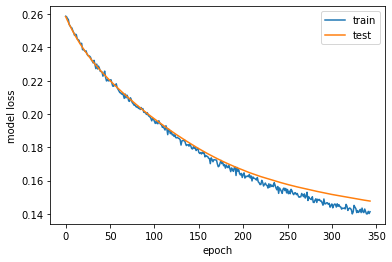

In [23]:
from tensorflow.keras.optimizers import SGD, Adam
#Now retrain the network with those optimal parameters
params = {
        # https://keras.io/guides/sequential_model/
    'hidden_layers': {
            'units': 64,
            'activation': 'relu',
            'use_bias': True,
            'kernel_initializer': 'GlorotUniform',
            'kernel_regularizer': None,
            'bias_regularizer': 'l2',
            'activity_regularizer': None,
            'kernel_constraint': None,
            'bias_constraint': None
            },
    'dropout_rate': 0.25,
    'compilation': {
            'optimizer': SGD(
                learning_rate=0.001,
                momentum=0.1
                ),
            'loss': losses.MeanSquaredError(),
            'metrics': [metrics.MeanSquaredError(), metrics.MeanAbsoluteError()],
            #'momentum': 0.
        },
    'fit': {
        'batch_size': 48,
        'epochs': 500,
        'callbacks' : [
            callbacks.EarlyStopping(monitor='loss', patience=20), 
            callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20)]
            }
          }

#Set up network
model = create_DNN(all_pcs, params['hidden_layers'], params['dropout_rate'])
model.compile(**params['compilation'])
history = model.fit(
    X_train,
    Y_train,
    validation_data=(X_validation, Y_validation),
    verbose=1,
    **params['fit']
)

print('Number of epochs run:', len(history.history['loss']))

# Calculate and print scores
print('Evaluating model performance on test set...')
scores = model.evaluate(X_test, Y_test, verbose=0)

max_metrics_name_length = len(max(model.metrics_names, key=len))
print()
print(' Scores '.center(max_metrics_name_length + 13, '='))
line = '{:<%i} : {:.4e}' % max_metrics_name_length
for i in range(len(model.metrics_names)):
    print(line.format(model.metrics_names[i], scores[i]))
print()

# print performance
print()
print('Test loss:', scores[0])

# look into training history

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

(6269, 500)
(6269, 1)
However, we know that this has a fail rate of at least 25%
There's an estimated 42 % functional sequences


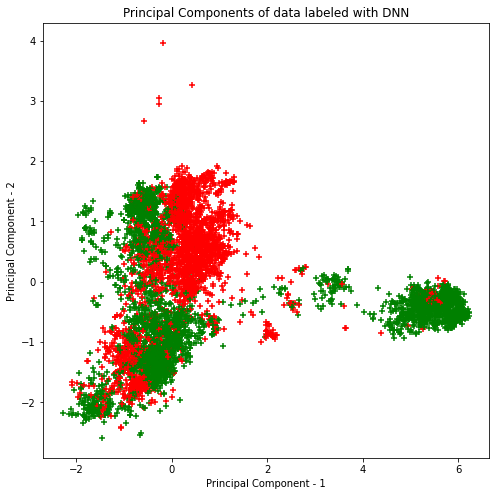

In [24]:
print(np.shape(unlab_pcs))
pred_labels = model.predict(unlab_pcs)
print(np.shape(pred_labels))

#red => 0 => functional_false; green => 1 => functional_true
colors = ['red','green']
groups = ['functional_false', 'functional_true']

fig = plt.figure(figsize=(8,8))
plt.scatter(unlab_pcs[:,0], unlab_pcs[:,1], c=pred_labels, marker = '+', label=groups,
            cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('Principal Component - 1')
plt.ylabel('Principal Component - 2')
#plt.legend(loc=2)
plt.title("Principal Components of data labeled with DNN")

print("However, we know that this has a fail rate of at least 25%")

print("There's an estimated " + str(int(np.sum(pred_labels)*100/6269)) + " % functional sequences")

As expected, this does not yield very good results: we have too few data (2133 units of dimension 500!)
But it was fun coding a NN, and it's good practice. Hoxever, fun is good, so we should use a better suited method: let's use random forest
(What follows relies heavily on the asociated Jupyter notebook)

In [25]:
#Apply Random Forest
#This is the random forest classifier
from sklearn.ensemble import RandomForestClassifier
#This is the extreme randomized trees
from sklearn.ensemble import ExtraTreesClassifier
#import time to see how perforamance depends on run time
import time
import warnings
#Comment to turn on warnings
warnings.filterwarnings("ignore")

input_data = all_lab_data
output_data = all_lab

# Steps to shuffle:
joined_lists = list(zip(input_data, output_data))
random.shuffle(joined_lists) # Shuffle "joined_lists" in place
input_data, output_data = zip(*joined_lists) # Undo joining
input_data = np.array(input_data)
output_data = np.array(output_data)
print(np.shape(input_data))

#Def fraction train/test/validation
fraction_train = 0.8
stop_1 = int(fraction_train*len(output_data))

X_train, Y_train = input_data[:stop_1], output_data[:stop_1]
X_test, Y_test = input_data[stop_1+1:], output_data[stop_1+1:]

#We will check 

min_estimators = 10
max_estimators = 101
classifer = RandomForestClassifier # BELOW WE WILL CHANGE for the case of extremly randomized forest 

n_estimator_range=np.arange(min_estimators, max_estimators, 10)
leaf_size_list=[2,3, 4, 5, 6, 7, 8]

m=len(n_estimator_range)
n=len(leaf_size_list)

#Allocate Arrays for various quantities

RFC_OOB_accuracy=np.zeros((n,m))
RFC_train_accuracy=np.zeros((n,m))
RFC_test_accuracy=np.zeros((n,m))
run_time=np.zeros((n,m))

print_flag=True

for i, leaf_size in enumerate(leaf_size_list):
    # Define Random Forest Classifier
    myRF_clf = classifer(
        n_estimators=min_estimators,
        max_depth=None, 
        min_samples_split=leaf_size, # minimum number of sample per leaf
        oob_score=True,
        random_state=0,
        warm_start=True # this ensures that you add estimators without retraining everything
    )
    for j, n_estimator in enumerate(n_estimator_range):
        
        print('n_estimators: %i, leaf_size: %i'%(n_estimator,leaf_size))
        
        start_time = time.time()
        myRF_clf.set_params(n_estimators=n_estimator)
        myRF_clf.fit(X_train, Y_train)
        run_time[i,j] = time.time() - start_time

    # check accuracy
        RFC_train_accuracy[i,j]=myRF_clf.score(X_train,Y_train)
        RFC_OOB_accuracy[i,j]=myRF_clf.oob_score_
        RFC_test_accuracy[i,j]=myRF_clf.score(X_test,Y_test)
        if print_flag:
            result = (run_time[i,j], RFC_train_accuracy[i,j], RFC_OOB_accuracy[i,j], RFC_test_accuracy[i,j])
            print('{0:<15}{1:<15}{2:<15}{3:<15}'.format("time (s)","train score", "OOB estimate","test score"))
            print('{0:<15.4f}{1:<15.4f}{2:<15.4f}{3:<15.4f}'.format(*result))

(2133, 1920)
n_estimators: 10, leaf_size: 2
time (s)       train score    OOB estimate   test score     
0.0946         0.9889         0.7327         0.7981         
n_estimators: 20, leaf_size: 2
time (s)       train score    OOB estimate   test score     
0.1163         0.9971         0.7661         0.8122         
n_estimators: 30, leaf_size: 2
time (s)       train score    OOB estimate   test score     
0.1242         0.9982         0.7708         0.8169         
n_estimators: 40, leaf_size: 2
time (s)       train score    OOB estimate   test score     
0.1394         1.0000         0.7773         0.8263         
n_estimators: 50, leaf_size: 2
time (s)       train score    OOB estimate   test score     
0.1500         1.0000         0.7784         0.8216         
n_estimators: 60, leaf_size: 2
time (s)       train score    OOB estimate   test score     
0.1746         1.0000         0.7755         0.8357         
n_estimators: 70, leaf_size: 2
time (s)       train score    OOB esti

time (s)       train score    OOB estimate   test score     
0.1168         0.9666         0.7878         0.8216         
n_estimators: 60, leaf_size: 7
time (s)       train score    OOB estimate   test score     
0.1251         0.9689         0.7849         0.8263         
n_estimators: 70, leaf_size: 7
time (s)       train score    OOB estimate   test score     
0.1464         0.9683         0.7902         0.8263         
n_estimators: 80, leaf_size: 7
time (s)       train score    OOB estimate   test score     
0.1726         0.9678         0.7931         0.8192         
n_estimators: 90, leaf_size: 7
time (s)       train score    OOB estimate   test score     
0.1783         0.9672         0.7925         0.8216         
n_estimators: 100, leaf_size: 7
time (s)       train score    OOB estimate   test score     
0.1853         0.9672         0.7907         0.8192         
n_estimators: 10, leaf_size: 8
time (s)       train score    OOB estimate   test score     
0.1082         0.944

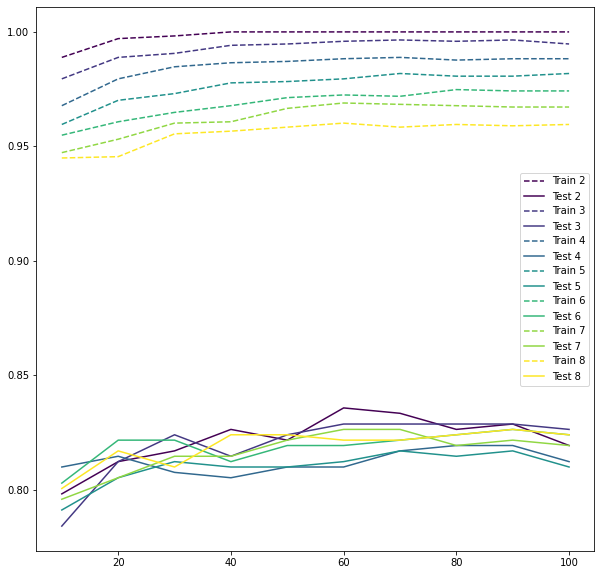

In [26]:
plt.figure(figsize=(10,10))
color = plt.cm.viridis(np.linspace(0, 1, len(leaf_size_list)))
for i, leaves in enumerate(leaf_size_list) :
    plt.plot()
    plt.plot(n_estimator_range,RFC_train_accuracy[i],'--', c=color[i], label='Train '+str(leaves))
    plt.plot(n_estimator_range,RFC_test_accuracy[i], c=color[i], label='Test '+str(leaves))
    plt.legend()
plt.show()

In [27]:
myRF_clf = classifer(
    n_estimators=min_estimators,
    max_depth=None, 
    min_samples_split=7, # minimum number of sample per leaf
    oob_score=True,
    random_state=0,
    warm_start=True # this ensures that you add estimators without retraining everything
)

myRF_clf.set_params(n_estimators=35)
myRF_clf.fit(X_train, Y_train)

predictions = myRF_clf.predict(np.array(encoded_data_unlab))
#functionality = [1 if predictions[0]==0 else 0 for prediction in predictions]

With 512 components, we keep 95% of the variance!
With the first 2 components, we only keep 7.6387908526858395% of the variance
There's an estimated 42 % functional sequences
Again, there's an 80% accuracy


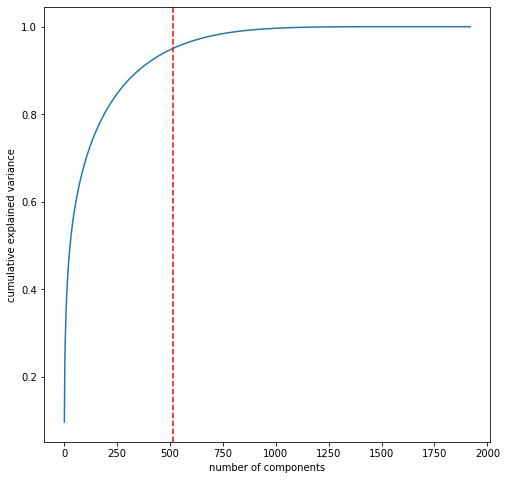

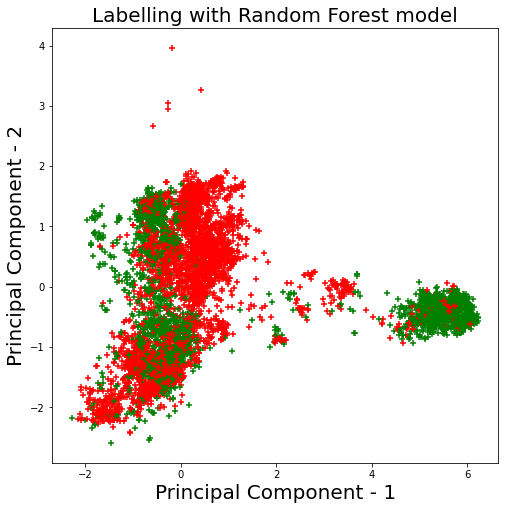

In [28]:
pcs_pred = apply_PCA(encoded_data_unlab)
visualize_pcs(pcs_pred, predictions, "Labelling with Random Forest model")

print("There's an estimated " + str(int(np.sum(predictions)*100/6269)) + " % functional sequences")
print("Again, there's an 80% accuracy")